## Éléments de la Figure N°6

/share/home/lelain/.conda/envs/gretsienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Extraction pour le modèle facebook/dinov2-base-imagenet1k-1-layer: 100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


Shape des Features : torch.Size([8000, 768])
Génération des t-SNE...


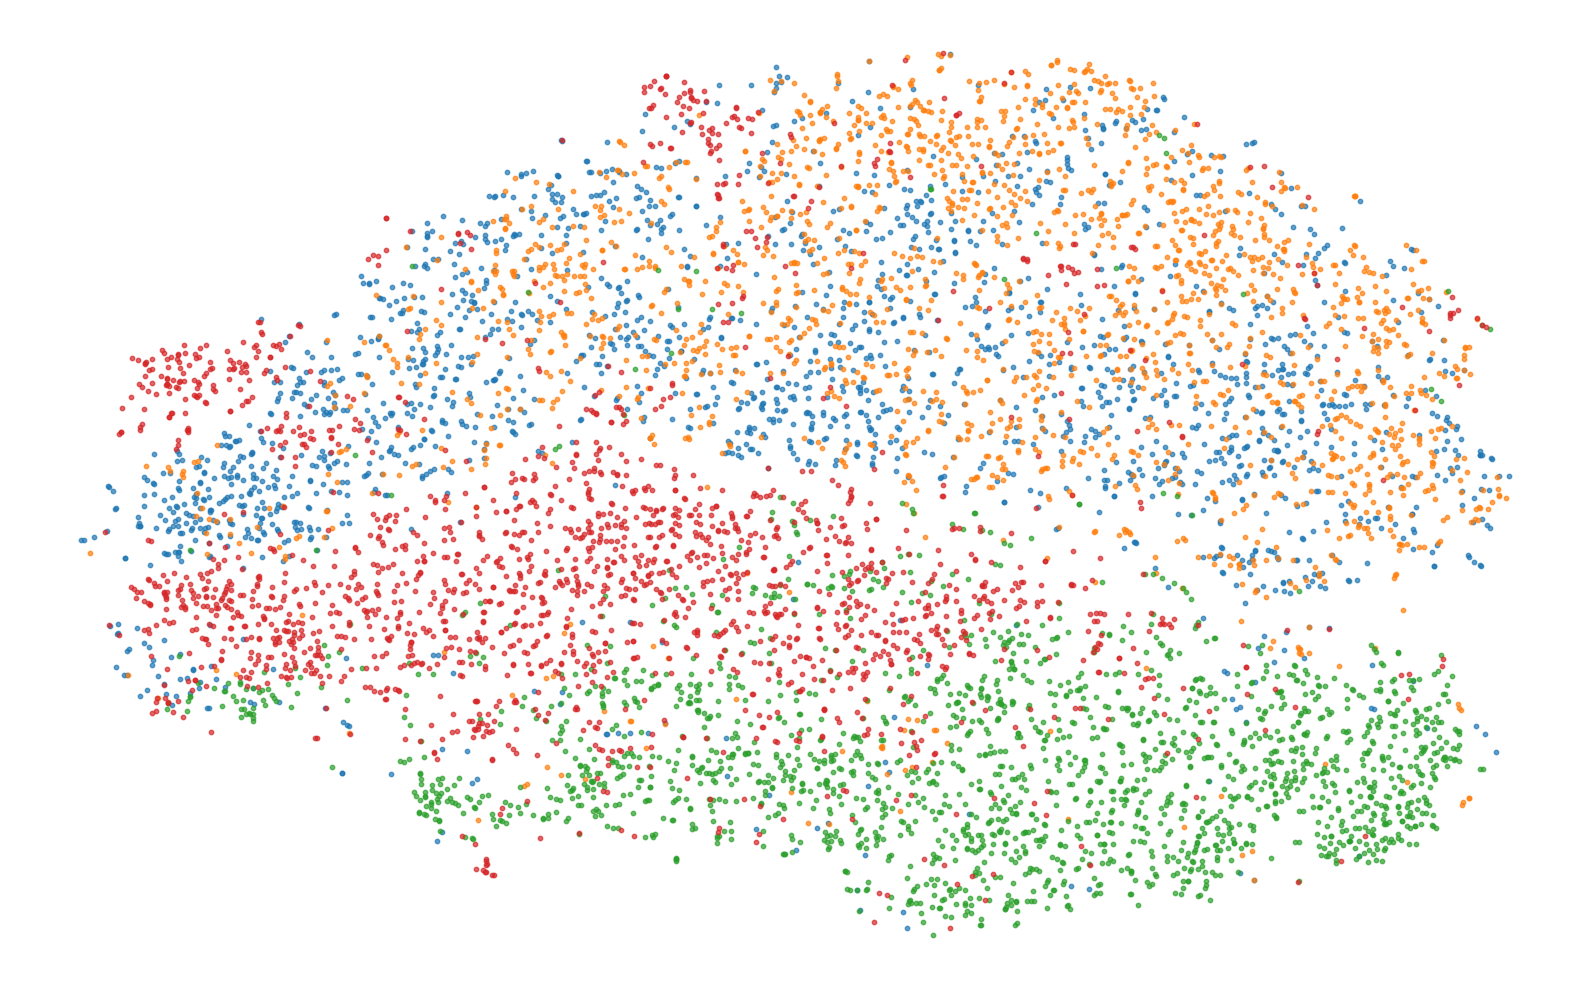

/share/home/lelain/.conda/envs/gretsienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Extraction pour le modèle matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy_mnist: 100%|██████████| 250/250 [02:00<00:00,  2.07it/s]


Shape des Features : torch.Size([8000, 768])
Génération des t-SNE...


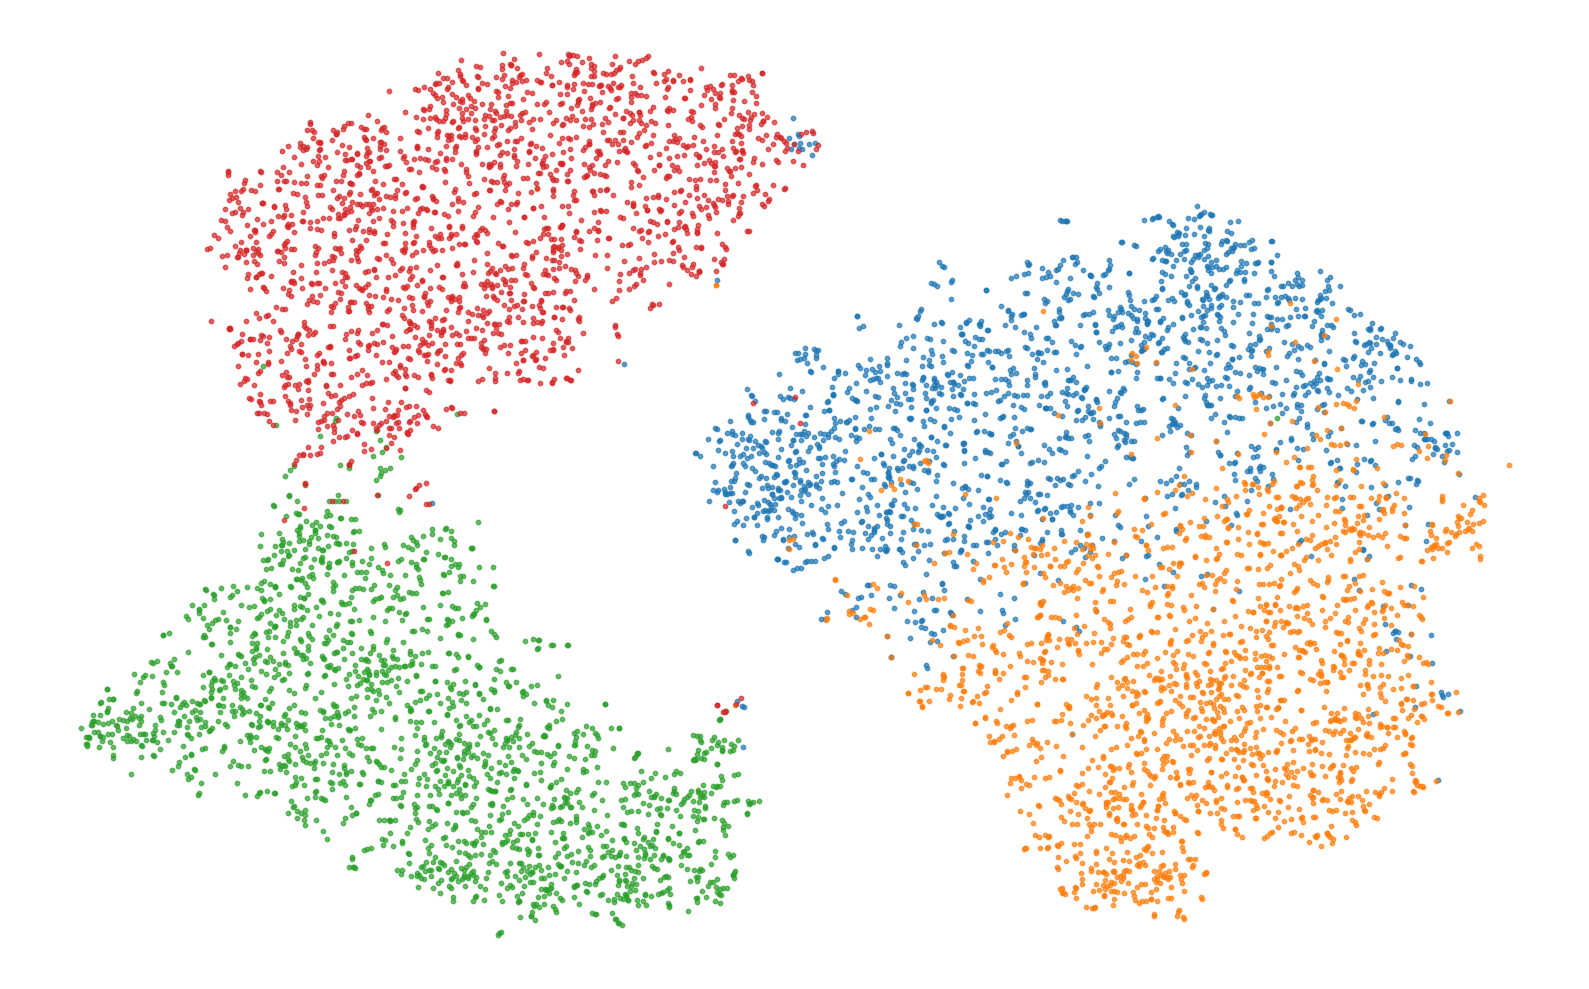

/share/home/lelain/.conda/envs/gretsienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Extraction pour le modèle matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy10-decals-finetuned-galaxy_mnist: 100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


Shape des Features : torch.Size([8000, 768])
Génération des t-SNE...


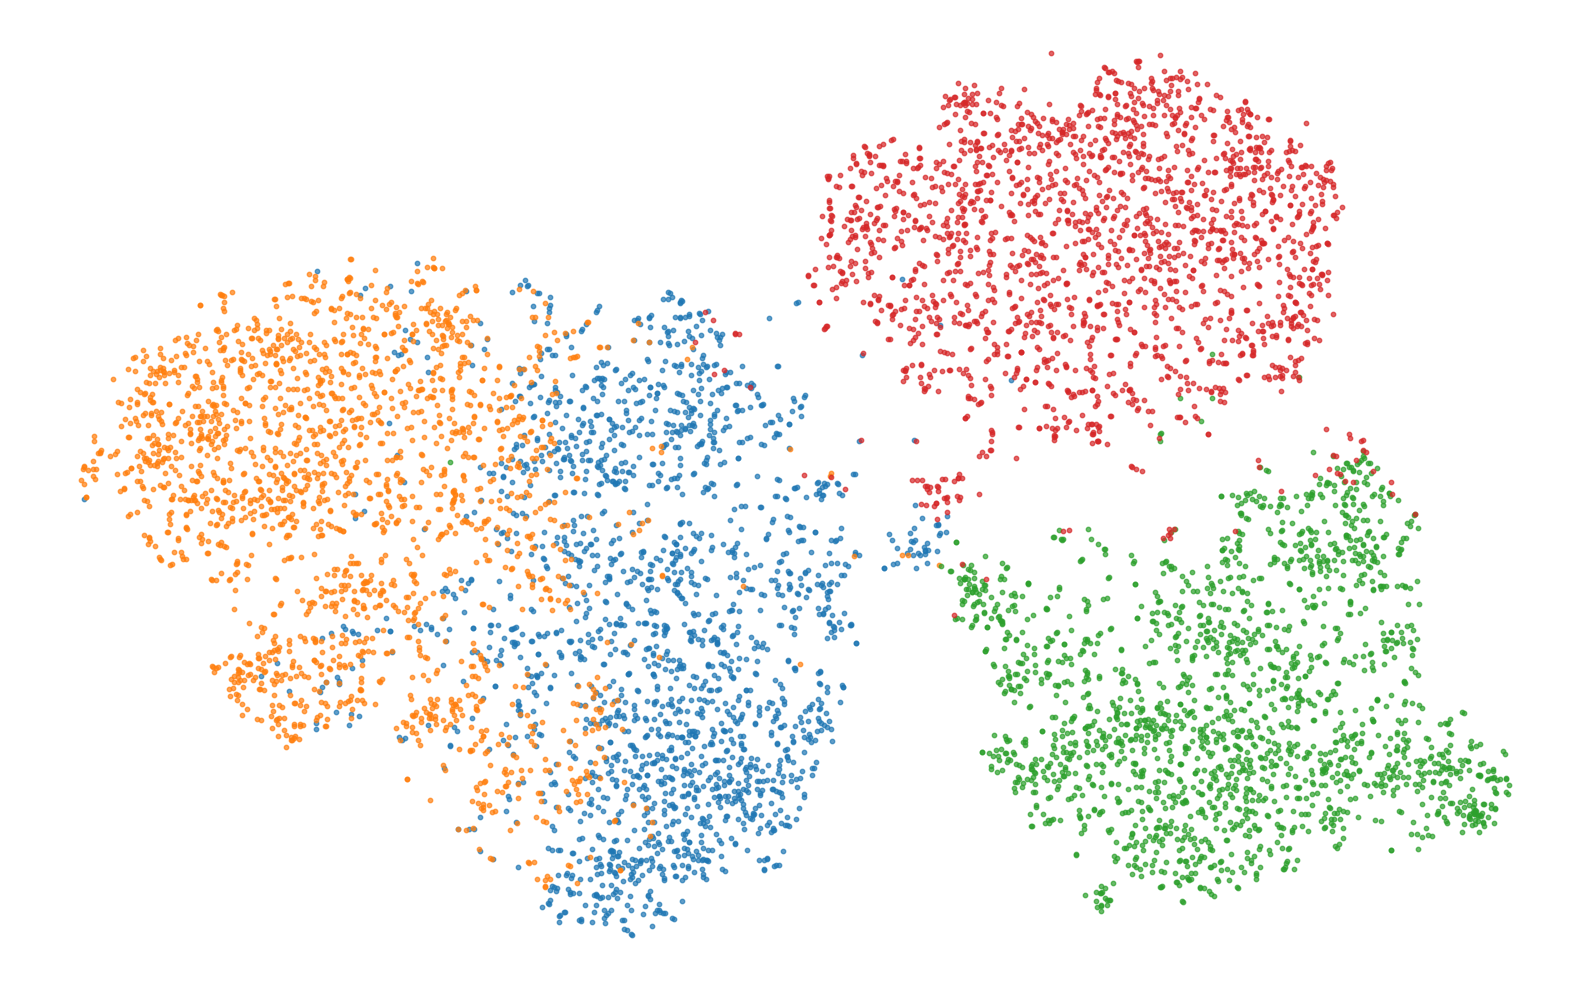

/share/home/lelain/.conda/envs/gretsienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Extraction pour le modèle matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy10-decals: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


Shape des Features : torch.Size([8000, 768])
Génération des t-SNE...


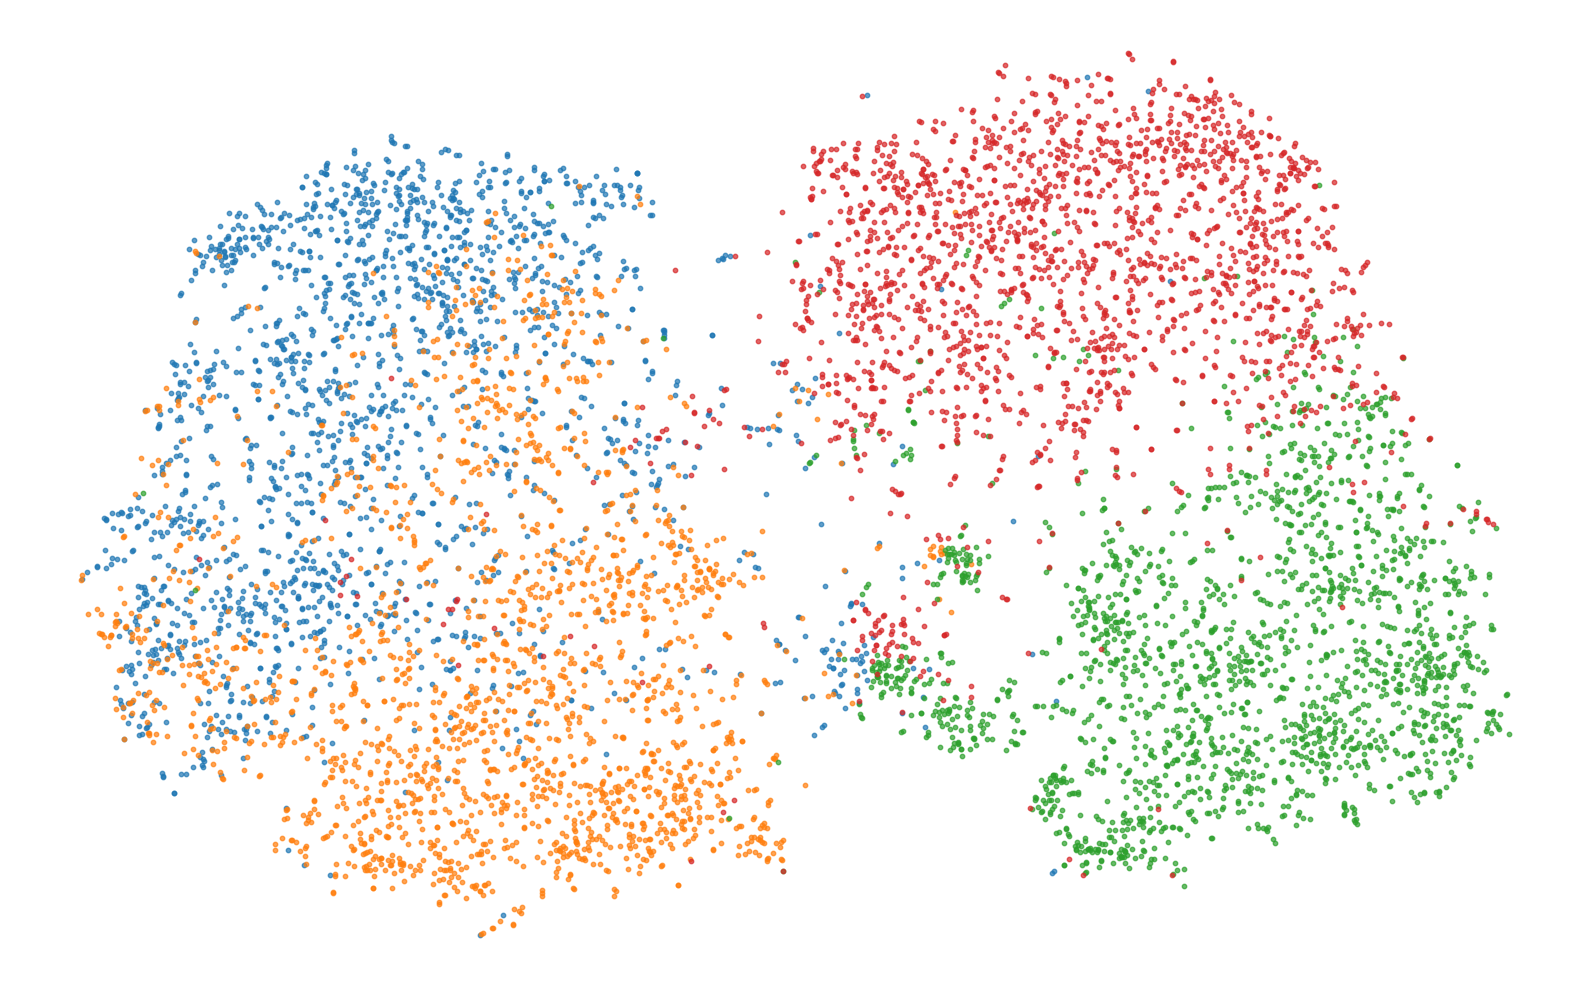

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from datasets import load_dataset
from sklearn.manifold import TSNE
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération des t-SNE pour les modèles DINOv2 avec le dataset Galaxy-MNIST
def plot_tsne(model_name, dataset, batch_size=32, filename="tsne.png"):

    # Chargement du modèle
    model = AutoModel.from_pretrained(model_name).to(device).eval()
    processor = AutoImageProcessor.from_pretrained(model_name)

    all_features = []
    all_labels = []
    all_ids = []
    global_id = 0  

    for i in tqdm(range(0, len(dataset), batch_size), desc="Extraction pour le modèle " + model_name):
        batch = dataset[i : i + batch_size]
        images = [img.convert("RGB") for img in batch['image']]
        inputs = processor(images=images, return_tensors="pt").to(device)
        # Nombre réel d'images dans le batch
        num_images = len(images) 

        with torch.no_grad():
            features = model(**inputs).last_hidden_state
            features = features[:, 0, :]
            
        all_features.append(features.cpu())
        all_labels.extend(batch['label'])
        batch_ids = list(range(global_id, global_id + num_images))
        all_ids.extend(batch_ids)
        global_id += num_images

    all_features = torch.cat(all_features)
    print(f"Shape des Features : {all_features.shape}")

    # t-SNE
    print("Génération des t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    tsne_results = tsne.fit_transform(all_features.numpy())

    x = tsne_results[:, 0]
    y = tsne_results[:, 1]
    labels_extract = np.array([labels[i] for i in all_labels])

    # plot
    fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
    for label in np.unique(labels_extract):
        ax.scatter(x[labels_extract == label], y[labels_extract == label], alpha=0.7, s=10)

    # Suppression des bordures
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Suppression des axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Fond blanc
    ax.set_facecolor('white')
    plt.tight_layout()
    
    # Sauvegarde avec des marges minimales
    plt.savefig("figures/" + filename, format="png", bbox_inches="tight", pad_inches=0)
    plt.show()

# Chargement du dataset
dataset_name = "matthieulel/galaxy_mnist"
batch_size = 32
dataset = load_dataset(dataset_name, split="train")

# Classes du dataset
labels = [
    'smooth and round',
    'smooth and cigar-shaped',
    'edge-on-disk',
    'unbarred spiral']

# Base DINOv2 générique
plot_tsne('facebook/dinov2-base-imagenet1k-1-layer', dataset, batch_size, filename="tsne_dinov2_base_generique_MNIST_clean-Figure6.png")
# Base DINOv2 générique full finetune Galaxy MNIST
plot_tsne('matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy_mnist', dataset, batch_size, filename="tsne_dinov2_base_galaxy_mnist-Figure6.png")
# DINOv2 full finetune Galaxy10DECaLS + full finetune Galaxy MNIST
plot_tsne('matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy10-decals-finetuned-galaxy_mnist', dataset, batch_size, filename="tsne_dinov2_galaxy10_decals_finetuned_galaxy_mnist-Figure6.png")
# DINOv2 full finetune Galaxy10DECaLS
plot_tsne('matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy10-decals', dataset, batch_size, filename="tsne_dinov2_galaxy10_decals-Figure6.png")


